In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
names = open("names.txt","r").read().splitlines()
names[:5]

['en', 'anastasia', 'kayla', 'alyssa', 'juliana']

In [3]:
# build a lookup table for character vocabulary
chars = sorted(list(set("".join(names))))
stoi = {s:i for i,s in enumerate(chars)}
# special tokens < start 26 and > end 27
stoi["<"] = 26
stoi[">"] = 27
# now reverse mapping . we will need this to decode and predict
itos = {i:s for s,i in stoi.items()}
print(itos)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: '<', 27: '>'}


In [4]:
# the first thing we have to do is to compile the dataset for the network
block_size = 3 # context length : how many chars we would use to predict the next char.

X,y = [],[]

for n, w in enumerate(names):
    context = [0]*block_size
    w = "<" + w + ">"
    for c in w:
        ix = stoi[c]
        X.append(context)
        y.append(ix)
        if n < 3: # show 3 examples
            print(context,ix)
        context = context[1:] + [ix]
X = torch.tensor(X)
y = torch.tensor(y)

# lets just use the first 30 examples first
sa_X = X[:5]
sa_y = y[:5]



[0, 0, 0] 26
[0, 0, 26] 4
[0, 26, 4] 13
[26, 4, 13] 27
[0, 0, 0] 26
[0, 0, 26] 0
[0, 26, 0] 13
[26, 0, 13] 0
[0, 13, 0] 18
[13, 0, 18] 19
[0, 18, 19] 0
[18, 19, 0] 18
[19, 0, 18] 8
[0, 18, 8] 0
[18, 8, 0] 27
[0, 0, 0] 26
[0, 0, 26] 10
[0, 26, 10] 0
[26, 10, 0] 24
[10, 0, 24] 11
[0, 24, 11] 0
[24, 11, 0] 27


In [5]:
# the dataset looks like as follows
X.shape , X.dtype , y.shape , y.dtype

(torch.Size([260179, 3]), torch.int64, torch.Size([260179]), torch.int64)

In [6]:
# and our sample dataset
sa_X.shape , sa_X.dtype , sa_y.shape , sa_y.dtype

(torch.Size([5, 3]), torch.int64, torch.Size([5]), torch.int64)

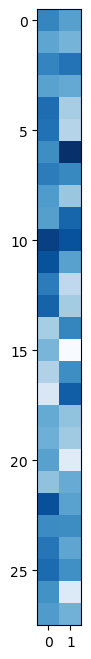

In [7]:
# called embedding C in joshua bengio's paper
# now our vocabulary size is 28 chars. we can embed this in 2 dimensional space for starters.
g=torch.Generator().manual_seed(123)
C = torch.randn(28,2,generator=g) # as we are going to right multiply this matrix
plt.figure(figsize=(15,8))
plt.imshow(C,cmap="Blues")

In [8]:
# so lets say e which is encoded as 4 in our stoi lookup table.
# will get a representation in R28 as it would one hot encoded with num_classes=28
# but we can just try to squeeze this into 2 dimesions.
e_representation_orig= F.one_hot(torch.tensor(5),num_classes=28).float()
e_rep = e_representation_orig @ C
e_representation_orig  , e_rep# so it just plucks out the 5th row from our C Embedding

(tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([ 0.6984, -1.4097]))

In [9]:
C[5]

tensor([ 0.6984, -1.4097])

In [10]:
# now we are going to go a bit crazy we can actually (lookup) or index our entire training examples all at once.
# so for now lets print . what a null character embedding is and what a < token embedding is
# remember our first example has no context so all 3 0s and the next example only has < token as context so two 0;s and 26 (<).
# remind yourself of the first 2 examples
print(X[:2])
# print Embedding for those:
print(C[[0,26]]) # note that i passed a list . i.e queries give me 0th and26th row

tensor([[ 0,  0,  0],
        [ 0,  0, 26]])
tensor([[ 0.3374, -0.1778],
        [ 0.1036, -2.1996]])


In [11]:
# so when we pass in the first 2 example in the C embedding we expect
# for the first example we get 3 enteries 0 gets mapped to R2 which is the first row in C. and they are repeated

# and for the second example the last representation would be of 26 so we expect it to be the second row from the above output
C[X[:2]], C[X[:2]].shape

(tensor([[[ 0.3374, -0.1778],
          [ 0.3374, -0.1778],
          [ 0.3374, -0.1778]],
 
         [[ 0.3374, -0.1778],
          [ 0.3374, -0.1778],
          [ 0.1036, -2.1996]]]),
 torch.Size([2, 3, 2]))

In [12]:
# so now that we understand we can pass in the entire example set in the lookup
C[X].shape # lets see what the shape is going to be like 
# in our above example we had X of shape 2,3 . 2 examples and 3 context .
# when we passed X in through C . we get 2,3,2 . 2,3 examples with each having a R2 representation.. therefore 2,3 and then ,2 the last 2 is the representation dimension . if we change C from 28,2 to 28,5 we would get 2,3,5.

# or if you want to read it as we have 39 examples as before and now the example has a representation of 3,2.
# and the representation is 3,2 because we have 3 context and each get a R2 representation

torch.Size([260179, 3, 2])

In [13]:
emb = C[X]

In [14]:
# so now lets construct our hidden layer
W1 = torch.randn(6,100) # again like the cell above it is important to understand why it is 6.
# it is 6 because each example can be represented in R6 . if we flatten out each example we get 39,6

# so the intermediate representation is going to push from R6 -> R100 . (we are going to right multiply this W)
# an now to add bias .
b1 = torch.randn(100) # 100 because each column of the weight matrix is allowed to get affine transformed


In [15]:
# but lets see how we deal with 32,3,2
# we will use the function torch.cat and torch.unbind to deal with this

x = torch.randn(2, 3)
print(x)
print(torch.cat((x, x, x), 0)) # vstack
print(torch.cat((x, x, x), 1)) # hstack

tensor([[-0.1889, -2.0949,  0.0823],
        [-0.6387, -0.4974,  0.1412]])
tensor([[-0.1889, -2.0949,  0.0823],
        [-0.6387, -0.4974,  0.1412],
        [-0.1889, -2.0949,  0.0823],
        [-0.6387, -0.4974,  0.1412],
        [-0.1889, -2.0949,  0.0823],
        [-0.6387, -0.4974,  0.1412]])
tensor([[-0.1889, -2.0949,  0.0823, -0.1889, -2.0949,  0.0823, -0.1889, -2.0949,
          0.0823],
        [-0.6387, -0.4974,  0.1412, -0.6387, -0.4974,  0.1412, -0.6387, -0.4974,
          0.1412]])


In [16]:
# unbind
# so it will pluck and return everytime it sees a new row
torch.unbind(torch.tensor([[1, 2, 3],
                           [4, 5, 6],
                           [7, 8, 9]]),1)

(tensor([1, 4, 7]), tensor([2, 5, 8]), tensor([3, 6, 9]))

In [17]:
# so the stratergy is that we want to unbind and hstack them on individual example

emb[:,0,:] # give me all the examples , the first context in R2
# similarly we can query for the rest of the 2 context and stack them

tensor([[ 0.3374, -0.1778],
        [ 0.3374, -0.1778],
        [ 0.3374, -0.1778],
        ...,
        [ 0.4965, -1.5723],
        [ 0.7671, -1.1925],
        [-2.1338,  1.0524]])

In [18]:
torch.cat( [emb[:,0,:] , emb[:,1,:] , emb[:,2,:] ] , axis=1)

tensor([[ 0.3374, -0.1778,  0.3374, -0.1778,  0.3374, -0.1778],
        [ 0.3374, -0.1778,  0.3374, -0.1778,  0.1036, -2.1996],
        [ 0.3374, -0.1778,  0.1036, -2.1996,  0.7671, -1.1925],
        ...,
        [ 0.4965, -1.5723,  0.7671, -1.1925, -2.1338,  1.0524],
        [ 0.7671, -1.1925, -2.1338,  1.0524, -0.3885, -0.9343],
        [-2.1338,  1.0524, -0.3885, -0.9343,  0.6177, -0.2876]])

In [19]:
# lets use unbind 
torch.unbind(emb,1) # that is we get a tuple of 3 . the first has the first 2 col the second has the next 2 and third has the last 2 col
# it splits in 2 columns each because we gave axis as 1 . and 1 index was for context. 3 context so 3 tuples returned
# so now we can just hstack these 3 tuples

(tensor([[ 0.3374, -0.1778],
         [ 0.3374, -0.1778],
         [ 0.3374, -0.1778],
         ...,
         [ 0.4965, -1.5723],
         [ 0.7671, -1.1925],
         [-2.1338,  1.0524]]),
 tensor([[ 0.3374, -0.1778],
         [ 0.3374, -0.1778],
         [ 0.1036, -2.1996],
         ...,
         [ 0.7671, -1.1925],
         [-2.1338,  1.0524],
         [-0.3885, -0.9343]]),
 tensor([[ 0.3374, -0.1778],
         [ 0.1036, -2.1996],
         [ 0.7671, -1.1925],
         ...,
         [-2.1338,  1.0524],
         [-0.3885, -0.9343],
         [ 0.6177, -0.2876]]))

In [20]:
torch.cat( torch.unbind(emb,1),1) # hstack them .

tensor([[ 0.3374, -0.1778,  0.3374, -0.1778,  0.3374, -0.1778],
        [ 0.3374, -0.1778,  0.3374, -0.1778,  0.1036, -2.1996],
        [ 0.3374, -0.1778,  0.1036, -2.1996,  0.7671, -1.1925],
        ...,
        [ 0.4965, -1.5723,  0.7671, -1.1925, -2.1338,  1.0524],
        [ 0.7671, -1.1925, -2.1338,  1.0524, -0.3885, -0.9343],
        [-2.1338,  1.0524, -0.3885, -0.9343,  0.6177, -0.2876]])

In [21]:
# an even better way .. but understand the above very very clearly
# view.. view is extremely efficient. cat takes whole new storage . view does not
emb.view(emb.shape[0],6)

tensor([[ 0.3374, -0.1778,  0.3374, -0.1778,  0.3374, -0.1778],
        [ 0.3374, -0.1778,  0.3374, -0.1778,  0.1036, -2.1996],
        [ 0.3374, -0.1778,  0.1036, -2.1996,  0.7671, -1.1925],
        ...,
        [ 0.4965, -1.5723,  0.7671, -1.1925, -2.1338,  1.0524],
        [ 0.7671, -1.1925, -2.1338,  1.0524, -0.3885, -0.9343],
        [-2.1338,  1.0524, -0.3885, -0.9343,  0.6177, -0.2876]])

In [22]:
# so now we can start pasing it through
h1= emb.view(emb.shape[0],6) @ W1 + b1
print(h1.shape)
a1 = torch.tanh(h1) # element wise operation
print(a1.shape)

torch.Size([260179, 100])
torch.Size([260179, 100])


In [23]:
# but lets just double check how it was broadcasted
W1.shape , b1.shape

(torch.Size([6, 100]), torch.Size([100]))

In [24]:
# 39,100
#   100 -> first you right align them

# the axis to be broadcasted needs to be 1 or empty
# here its empty

# that is to broadcast them we would vstack bias 39 times to make it 39,100
# that is the same row is being appended .. each example get the same bias .
# so its ok!

In [25]:
W2 = torch.randn(100,28)
b2 = torch.randn(28)

In [26]:
logits = h1 @ W2 + b2 # note the final is a linear layer . most of the time it is
count = logits.exp() # so now its all positive and we can interpret them as counts 
prob = count/count.sum(axis=1,keepdims=True)

In [27]:
prob.shape

torch.Size([260179, 28])

In [28]:
prob[0].sum()

tensor(1.)

In [29]:
# probabilty of right guess for the examples
prob[torch.arange(emb.shape[0]),y]


tensor([4.1152e-06, 2.3604e-17, 2.5049e-40,  ..., 7.6959e-22, 2.0009e-37,
        0.0000e+00])

In [30]:
torch.log(torch.tensor(0))

tensor(-inf)

In [31]:
# make negative log likelihood
-1 * prob[torch.arange(emb.shape[0]),y].log().mean()
# -1 * prob[torch.arange(5),y[:5]].log().mean()
# inf is unfortunate 😬
F.cross_entropy(logits,y)


tensor(44.3379)

In [32]:
# lets just make all of this a bit respeectable
g = torch.Generator().manual_seed(123)
C = torch.randn(28,2,generator=g)
W1 = torch.randn(6,100)
b1 = torch.randn(100)
W2 = torch.randn(100,28)
b2 = torch.randn(28)
parameters = [C, W1, W2, b1, b2]

In [33]:
sum(p.nelement() for p in parameters)

3584

In [34]:
for p in parameters:
    p.requires_grad = True

In [75]:
emb = C[X]
h = torch.tanh( emb.view(emb.shape[0],6) @ W1 + b1)
logit = h @ W2 + b2
# count = logits.exp()
# prob = count/count.sum(1,keepdim=True)
# loss = -1 * prob[torch.arange(emb.shape[0]),y].log().mean()
loss = F.cross_entropy(logit,y)

In [76]:
loss

tensor(7.8013, grad_fn=<NllLossBackward0>)

In [77]:
for p in parameters:
    p.grad = None # flush
loss.backward()
for p in parameters:
    p.data = p.data - (0.1 * p.grad )